# Spin-period evolution of neutron stars interacting with a supernova fallback disk

In [1]:
#!/usr/bin/env python3
"""propeller_parameter_search_Bdecay.ipynb: a notebook to recreate results of Ronchi et al. (2022)"""

__author__ = "Michele Ronchi"
__copyright__ = "Copyright 2022"
__credits__ = ["Michele Ronchi"]
__license__ = "MIT"
__maintainer__ = "Michele Ronchi"
__email__ = "ronchi@ice.csic.es"

This notebook contains the code to perform a parameter study of the spin-period evolution of pulsars interacting with supernova fallback disk as in [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704). By using general assumptions for the pulsar spin period and magnetic field at birth, initial fallback accretion rates and including magnetic field decay, we find that very long spin periods ($100 \, {\rm s}$) can be reached in the presence of strong, magnetar-like magnetic fields ($\gtrsim 10^{14} \, {\rm G}$) and moderate initial fallback accretion rates ($10^{22-27} \, {\rm g \, s^{-1}}$). 
In addition, we study the cases of two recently discovered periodic radio sources, the pulsar MTP0013 (Caleb et al. 2022 in press)($P = 75.9 \, {\rm s}$) and the radio transient GLEAM-X J162759.5-523504.3 ([Hurley-Walker et al. 2022](https://www.nature.com/articles/s41586-021-04272-x)) ($P = 1091 \, {\rm s}$), in light of our model. 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy import interpolate
from scipy.integrate import odeint
from scipy.integrate import trapz
from scipy.optimize import curve_fit
from typing import Tuple

import constants as const
import plot_settings

In [3]:
# Characteristic neutron star radius in [cm].
NS_radius = 1.1e6

# Characteristic neutron star mass in solar masses.
NS_mass = 1.4 * const.M_SUN

# Dimensionless coefficients k_0, k_1, k_2 for a force-free magnetosphere
# taken from Spitkovsky (2006) and Philippov et al. (2014).
# For comparison, in vacuum k_0 = 0 and k_1 = k_2 = 2/3.
k_coefficients = [1.0, 1.0, 1.0]

# Canonical neutron star moment of inertia in [g cm^2] assuming a perfect solid sphere.
NS_inertia = 2.0 / 5.0 * NS_mass * NS_radius ** 2

# Auxiliary quantity beta as defined in eq. (72) of Pons & Vigano (2019).
beta = 1./4. * NS_radius ** 6 / (NS_inertia * const.C ** 3)

# Assume an inclination angle in [rad].
chi = 0.

# Incorporate the inclination angle dependence into a constant.
beta_1 = beta * (k_coefficients[0] + k_coefficients[1] * np.sin(chi) ** 2)

# Dominant conductivity based on phonon or impurity scattering, in [1/s].
# For details see Cumming et al. (2004) or Gourgouliatos and Cumming (2014).
sigma = 1e24

# Characteristic length scale of the magnetic field in [cm].
L = 1e5

# Characteristic electron density in [g/cm^3].
n_e = 1e35

# Eddington luminosity assuming Thompson scattering in [erg / s].
L_Edd = 4. * np.pi * const.G * NS_mass * const.M_P * const.C / const.SIGMA_T

# Circularization radius of the disk in [cm].
r_d = 1.e8

# Initial disk central temperature in [K].
T_c = 1.e6

# typical initial viscousity timescale of the disk in [s] see Menou et al. 2001.
t_v = 2080. * (T_c/1.e6)**(-1.) * (r_d/10**8)**(1./2.)

# Maximum time reached by the evolution in [yr].
t_max = 1.e7

# Power-law index for the disk accretion rate decay.
alpha = 1.2

# Power-law index for the disk outer radius evolution.
gamma = 0.44

# Initial spin period of the neutron star in [s].
P_in = 0.01

# Range of initial accretion rate for the fall-back disk in [g s^-1].
Mdot_d0_min = 1.e19  
Mdot_d0_max = 1.e29  

# Range of initial magnetic fields in [G].
B0_min = 1.e12 
B0_max = 1.e15

In [4]:
def timescale_Ohm(L: float, sigma: float) -> float:
    """
    Calculating the ohmic diffusion timescale for a given conductivity and characteristic magnetic
    field length scale. Note that for our purposes, we neglect the fact that both quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the ohmic diffusion process.

    Args:
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        sigma (float): conductivity of the dominating dissipative process, measure in [1/s].

    Returns:
        (float): ohmic diffusion timescale in [yr].
    """

    tau_Ohm = 4 * np.pi * sigma * L ** 2 / (const.C ** 2)
    
    return tau_Ohm


def timescale_Hall(B: float, L: float, n_e: float) -> float:
    """
    Calculating the Hall timescale for a given field strength, characteristic magnetic field length
    scale and electron density. Note that for our purposes, we neglect the fact that all quantities can
    vary significantly with depth inside the neutron star, and we simply use effective quantities
    that reflect the conservative Hall process.
    B will be identified with the initial dipolar magnetic field components at the pulsars' pole.

    Args:
        B (float): (local) magnetic field strength, measured in [G].
        L (float): characteristic length scale on which the magnetic field varies, measured in [cm].
        n_e (float): electron density, measured in [g/cm^3].

    Returns:
        (float): Hall timescale in [yr].
    """

    tau_Hall = (
        4 * np.pi * const.E * n_e * L ** 2 / (const.C * B)
    )

    return tau_Hall


def field_derivative(B: float, B_initial: float) -> float:
    """
    Calculating the change in the magnetic field strength of a pulsar based on a simplified
    differential equation (see eq. (18) of Aguilera et al. (2008)) that captures the
    characteristics of more complicated numerical simulations of pulsar magnetic field
    evolution, i.e., at early timescales the Hall evolution dominates, while at late times
    the exponential magnetic field decay due to Ohmic dissipation kicks in. Note that as
    explained in Aguilera et al. (2008) the Hall timescale corresponds to that of the initial
    field strength.

    Args:
        B (float): pulsar's magnetic field magnitudes evolving with time, measured in [G].
        B_initial (float): pulsar's initial magnetic field magnitudes, measured in [G].

    Returns:
        (float): magnetic field derivatives for a simulated pulsars in [G/yr].
    """

    tau_Ohm = timescale_Ohm(L, sigma)
    tau_Hall = timescale_Hall(B_initial, L, n_e)

    B_deriv = - B / tau_Ohm - B ** 2 / (tau_Hall * B_initial)
    
    return B_deriv

In [5]:
# Example of Hall and Ohmic timescale values for B0 = 10^14 G in [yr].
print(timescale_Hall(1.e14, L, n_e) / const.YR_TO_S)
print(timescale_Ohm(L, sigma) / const.YR_TO_S)

63843.04741742556
4433654.543523996


In [6]:
def radius_magnetospheric(B: float, Mdot: float) -> float:
    """
    Magnetospheric radius as a function of the magnetic field of the neutron star and the accretion rate.
    
    Args:
        B (float): value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].
        Mdot (float): inflow rate in [g s^-1].

    Returns:
        (float): magnetosperic radius in [cm].
    """
        
    mu = B * NS_radius**3 / 2.
    
    r_m = 0.5 * ( mu ** 4 / (2 * const.G * NS_mass * Mdot ** 2)) ** (1./7.)
        
    return r_m
    

def radius_lc(omega: float) -> float:
    """
    light cylinder radius as a function of the spin frequency.
    
    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): light cylinder radius in [cm].
    """
    
    r_lc = const.C / omega
        
    return r_lc
   
    
def radius_corotation(omega: float) -> float:
    """
    corotation radius as a function of the spin frequency.
    
    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): corotation radius in [cm].
    """
    
    r_cor = ( const.G * NS_mass / (omega ** 2) ) ** (1./3.)
        
    return r_cor

In [7]:
def accretion_rate_Edd_rmag(B: float) -> float:
    """
    Eddington limit of the accretion rate at the magnetospheric radius.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].

    Returns:
        (float): Eddington limit of the accretion rate at the magnetospheric radius in [g s^-1].
    """  
    
    # Magnetic moment.
    mu = B * NS_radius**3 / 2.
    
    Mdot_Edd =  (L_Edd / (const.G * NS_mass)) ** (7./9.) * ( mu ** 4. / (2. * const.G * NS_mass) ) ** (1./9.)
    
    return Mdot_Edd

In [8]:
def accretion_rate_Edd_rlc(omega: float) -> float:
    """
    Eddington limit of the accretion rate at the light cylinder radius.

    Args:
        omega (float): value of the spin frequency measured in [1/s].

    Returns:
        (float): Eddington limit of the accretion rate at the light cylinder radius in [g s^-1].
    """  
    
    # Light cylinder radius.
    r_lc = radius_lc(omega)
    
    Mdot_Edd = 2 * L_Edd * r_lc / (const.G * NS_mass)
    
    return Mdot_Edd

In [9]:
def disk_accretion_rate_t(Mdot_d0: float, alpha: float, t:float) -> float:
    """                                                          
    Accretion rate inside the disk as a function of time.

    Args:
        Mdot_d0(float): initial maximum disk accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the disk accretion rate. 
        t(float): time in [s]. 

    Returns:
        (float): disk accretion rate in [g s^-1] as a function of time.
    """          
            
    Mdot_d = Mdot_d0 * (1 + t / t_v) ** (-alpha)
            
    return Mdot_d

In [10]:
def disk_outer_radius_t(t:float) -> float:
    """                                                          
    Accretion rate inside the disk as a function of time.

    Args:
        t(float): time in [s]. 

    Returns:
        (float): disk accretion rate in [g s^-1] as a function of time.
    """          
        
    r_out = r_d * (1 + t / t_v) ** gamma
            
    return r_out

In [11]:
def disk_accretion_rate_in_t(B: float, omega: float, Mdot_d0: float, alpha: float, t:float, t_disrupt: float = None) -> float:
    """
    Accretion rate in the inner boundary of the disk as a function of time.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].
        omega (float): value of the spin frequency measured in [1/s].
        Mdot_d0(float): initial maximum disk accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the disk accretion rate. 
        t(float): time in [s]. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (float): accretion rate at the inner radius of the disk in [g s^-1] as a function of time.
    """ 
    
    # Compute Eddington limits on the accretion rate [g s^-1]
    Mdot_Edd_mag = accretion_rate_Edd_rmag(B)
    Mdot_Edd_lc = accretion_rate_Edd_rlc(omega)
    
    # The disk inner radius is the smaller between the magnetospheric radius and the light cylinder radius.
    Mdot_Edd = min(Mdot_Edd_mag, Mdot_Edd_lc)

    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = 0.
    
    # Limit the accretion rate at the inner disk edge to the Eddington limit.
    if Mdot_d < Mdot_Edd:
        Mdot_din = Mdot_d
    elif Mdot_d >= Mdot_Edd:
        Mdot_din = Mdot_Edd
    
    # When the disk is disrupted because r_in > r_out set the accretion rate to 0 afterwords.
    if (t_disrupt is not None):
        if (t > t_disrupt):
            Mdot_din = 0.

    return Mdot_din

In [12]:
def disk_accretion_rate_in_t_numpy(B: float, omega: np.ndarray, Mdot_d0: float, alpha: float, t:np.array, t_disrupt: float = None) -> float:
    """
    Accretion rate in the inner boundary of the disk as a function of time optimized for numpy array.

    Args:
        B (float): value of the dipolar component of the magnetic field at the magnetic pole measured in [G].
        omega (np.ndarray): value of the spin frequency measured in [1/s].
        Mdot_d0(float): initial maximum fallback rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the inflow rate. 
        t(np.ndarray): time in [s]. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (np.ndarray): fall back accretion rate in [g s^-1] as a function of time.
    """      
    
    # Compute Eddington limits on the accretion rate [g s^-1].
    Mdot_Edd_mag = accretion_rate_Edd_rmag(B)
    Mdot_Edd_lc = accretion_rate_Edd_rlc(omega)
    
    # The disk inner radius is the smaller between the magnetospheric radius and the light cylinder radius.
    Mdot_Edd = np.minimum(Mdot_Edd_mag, Mdot_Edd_lc)

    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = np.zeros(len(t))
    
    # Limit the accretion rate at the inner disk edge to the Eddington limit.
    Mdot_din[Mdot_d >= Mdot_Edd] = Mdot_Edd[Mdot_d >= Mdot_Edd]
    Mdot_din[Mdot_d < Mdot_Edd] = Mdot_d[Mdot_d < Mdot_Edd]
    
    # When the disk is disrupted because r_in > r_out set the accretion rate to 0 afterwords.
    if t_disrupt is not None:
        Mdot_din[t > t_disrupt] = 0.
    
    return Mdot_din

In [13]:
def omega_keplerian(r: float) -> float:
    """
    keplerian orbital frequency as a function of the radius.
    
    Args:
        r (float): distance from the star in [cm].

    Returns:
        (float): keplerian orbital frequency in [1/s].
    """
    
    omega_k = ( const.G * NS_mass / (r ** 3) ) ** (1./2.)
        
    return omega_k

In [14]:
def derivatives_spin_evolution(t:float, initial_cond:np.ndarray, B0:float, Mdot_d0:float, alpha:float, t_disrupt: float = None) -> float:
    """
    Derivative of the magnetic field and spin frequency for the three phases, direct accretion, propeller and ejector.
    See Metzger et al. (2018).

    Args:
        t(float): time variable in [s],
        initial_cond(np.ndarray): current value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G] and value of the spin frequency measured omega in [1/s].
        B0 (float): initial value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G].
        Mdot_d0 (float): accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate.   
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (float): Derivative of the magnetic field and spin frequency for the three phases, direct accretion, propeller and ejector [s^-2].
    """    
    B = initial_cond[0]
    omega = initial_cond[1]
    
    Bdot = field_derivative(B, B0)
    
    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = disk_accretion_rate_in_t(B, omega, Mdot_d0, alpha, t, t_disrupt)
    
    r_m = radius_magnetospheric(B, Mdot_din)
    r_c = radius_corotation(omega)
    r_lc = radius_lc(omega)          
    
    omega_k_rns = omega_keplerian(NS_radius)
    omega_k_rm = omega_keplerian(r_m)
    omega_k_rlc = omega_keplerian(r_lc)
    
    omegadot = 0.
        
    if (r_m <= NS_radius):
        # direct accretion phase with likely buried magnetic field.
        omegadot = Mdot_din * NS_radius ** 2 / NS_inertia * (omega_k_rns - omega) - (r_lc/NS_radius)**2 * beta_1 * B**2 * omega ** 3
        
    elif (r_m > NS_radius) & (r_m < r_lc):
        # propeller (r_m > r_c) or direct accretion phase (r_m < r_c).
        omegadot = Mdot_din * r_m ** 2 / NS_inertia * (omega_k_rm - omega) - (r_lc/r_m)**2 * beta_1 * B**2 * omega ** 3
    
    elif (r_m >= r_lc):
        # Ejector phase.
        omegadot = Mdot_din * r_lc ** 2 / NS_inertia * (omega_k_rlc - omega) - beta_1 * B**2 * omega ** 3
        
    derivatives = np.array([Bdot, omegadot])
    
    return derivatives

In [15]:
def omegadot_numpy(t:np.ndarray, omega:np.ndarray, B:np.ndarray, Mdot_d0:float, alpha:float, t_disrupt: float = None) -> float:
    """
    Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector optimized for numpy arrays.
    See Metzger et al. (2018).

    Args:
        t(np.ndarray): time variable in [s],
        omega (np.ndarray): value of the spin frequency measured in [1/s].
        B (np.ndarray): value of the dipolar component of the magnetic field at the
        magnetic pole measured in [G] as a function of time.
        Mdot (float): accretion rate in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate. 
        t_disrupt(float): time in [s] when the disk is disrupted because r_in > r_out.

    Returns:
        (np.ndarray): Derivative of the spin frequency for the three phases, direct accretion, propeller and ejector [s^-2].
    """      
    
    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, t)
    Mdot_din = disk_accretion_rate_in_t_numpy(B, omega, Mdot_d0, alpha, t, t_disrupt)
    
    r_m = radius_magnetospheric(B, Mdot_din)
    r_c = radius_corotation(omega)
    r_lc = radius_lc(omega)
    
    omegadot = np.zeros(len(t))
        
    omega_k_rns = omega_keplerian(NS_radius)
    omega_k_rm = omega_keplerian(r_m)
    omega_k_rlc = omega_keplerian(r_lc)
    
    cond_acc = (r_m <= NS_radius)
    cond_prop_acc = (r_m > NS_radius) & (r_m < r_lc)
    cond_ej = (r_m >= r_lc)
    
    omegadot[cond_acc] = Mdot_din[cond_acc] * NS_radius ** 2 / NS_inertia * (omega_k_rns - omega[cond_acc]) - (r_lc[cond_acc]/NS_radius)**2 * beta_1 * B[cond_acc]**2 * omega[cond_acc] ** 3
    omegadot[cond_prop_acc] = Mdot_din[cond_prop_acc] * r_m[cond_prop_acc] ** 2 / NS_inertia * (omega_k_rm[cond_prop_acc] - omega[cond_prop_acc]) - (r_lc[cond_prop_acc]/r_m[cond_prop_acc])**2 * beta_1 * B[cond_prop_acc]**2 * omega[cond_prop_acc] ** 3
    omegadot[cond_ej] = Mdot_din[cond_ej] * r_lc[cond_ej] ** 2 / NS_inertia * (omega_k_rlc[cond_ej] - omega[cond_ej]) - beta_1 * B[cond_ej]**2 * omega[cond_ej] ** 3
     
    return omegadot

In [16]:
def rotational_evolution(
    B0: float,
    P_initial: float,
    Mdot_d0: float,
    alpha: float,
    t_max: float,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, bool, bool, float]:
    """
    Evolving the neutron stars' spin period in case of interaction with a fall-back disk.

    Args:
        B0 (float): initial value of the magnetic field magnitude, measured in [G].
        P_initial (float): pulsars' initial rotation periods, measured in [s].
        Mdot_d0 (float): initial accretion rate at the beginning of fall-back in [g s^-1].
        alpha(float): index of the power law for the time evolution of the accretion rate. 
        t_max (float): maximum time for the evolution in [yr].

    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
        np.ndarray, np.ndarray, bool, bool, float): time array in [yr], spin period as a 
        function of time in [s], derivative of the spin period in [s/s], magnetic field as 
        a function of time in [G], 
    """

    # Define the time grid in s.
    t_max = t_max * const.YR_TO_S
    time_grid = np.logspace(np.log10(10.), np.log10(t_max), 2000) 

    # Set the initial conditions.
    omega_initial = 2.*np.pi / P_initial
    
    initial_conditions = np.array([B0, omega_initial])
    
    # Evolve in time.
    evol_output = np.array(
            odeint(
                derivatives_spin_evolution,
                y0=initial_conditions,
                t=time_grid,
                args=(B0, Mdot_d0, alpha,),
                tfirst=True,
            )
        )

    # Extract the evolution output for B and omega.
    B_t = np.array(evol_output[:, 0].tolist())
    omega_t = np.array(evol_output[:, 1].tolist())
        
    Mdot_d = disk_accretion_rate_t(Mdot_d0, alpha, time_grid)
    Mdot_din = disk_accretion_rate_in_t_numpy(B_t, omega_t, Mdot_d0, alpha, time_grid)
    
    r_m = radius_magnetospheric(B_t, Mdot_din)
    r_lc = radius_lc(omega_t)
    
    # Compute the inner and outer radius of the disk. 
    r_in = np.minimum(r_m, r_lc)
    r_out = disk_outer_radius_t(time_grid)
        
    # Check if the field could be buried in the initial stages (before the field decays on a Ohmic timescale ~10^6 yr).
    buried = False
    if np.min(r_m[time_grid / const.YR_TO_S < 10^6]) < NS_radius:
        buried = True
        print("buried:", buried)
    
    # Check if the disk is disrupted because r_in > r_out and save the time when this happens.
    disk_disrupted = False
    t_disrupt = None
    if any(r_in > r_out):
        disk_disrupted = True
        t_disrupt = time_grid[r_in > r_out]
        t_disrupt = t_disrupt[0]
        
        # Re-run the evolution considering the time when the disk should be disrupted.
        evol_output = np.array(
            odeint(
                derivatives_spin_evolution,
                y0=initial_conditions,
                t=time_grid,
                args=(B0, Mdot_d0, alpha, t_disrupt),
                tfirst=True,
            )
        )
             
        print("disk disrupted:", disk_disrupted)
        
    omega_t = np.array(evol_output[:, 1].tolist()) 
    P_t = 2*np.pi / omega_t
          
    omegadot_t = omegadot_numpy(time_grid, omega_t, B_t, Mdot_d0, alpha, t_disrupt)
    Pdot_t = - P_t**2 / (2.*np.pi) * omegadot_t

    Mdot_din = disk_accretion_rate_in_t_numpy(B_t, omega_t, Mdot_d0, alpha, time_grid, t_disrupt)
    
    r_m = radius_magnetospheric(B_t, Mdot_din)
    r_c = radius_corotation(omega_t)
    r_lc = radius_lc(omega_t)

    return time_grid / const.YR_TO_S, P_t, Pdot_t, B_t, r_m, r_c, r_lc, Mdot_d, Mdot_din, buried, disk_disrupted, t_disrupt

## Example of spin-period evolution

Example of neutron star spin-down in presence of a fallback disk on a timescale of $10^7 \, {\rm yr}$. The top panel shows the total disk accretion $\dot{M}_{\rm d}$ and the Eddington-limited accretion rate at the inner radius $\dot{M}_{\rm d, in}$. The middle panel illustrates the evolution of the three critical radii $r_{\rm cor}$, $r_{\rm m}$, $r_{\rm lc}$. The evolution of the disk's inner and outer radii is highlighted by the gray lines. The bottom panel shows the resulting time evolution of the spin period. We assume an initial spin period $P_0 = 10 \, {\rm ms}$, initial magnetic field $B_0 = 4 \times 10^{14} \, {\rm G}$ and an initial disk accretion rate $\dot{M}_{\rm d,0} = 10^{24} \, {\rm g \, s^{-1}}$. We also highlight the duration of the ejector and propeller phases by shading the background in blue and red, respectively. See fig. 2 in [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704).

In [17]:
time, P, Pdot, _, r_m, r_c, r_lc, Mdot_d, Mdot_din, _, _, _ = rotational_evolution(4.e14, P_in, 1.e24, alpha, t_max)

# Find the time when the star enter in the propeller phase.
#t_prop = time[(r_m > r_c) & (r_m < r_lc)]
#t_prop = t_prop[0]
t_prop = 1000

# Compute the inner and outer radius of the disk.
r_in = np.minimum(r_m, r_lc)
r_out = disk_outer_radius_t(time * const.YR_TO_S)

/home/michele/miniconda3/envs/pulsar_fallback/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


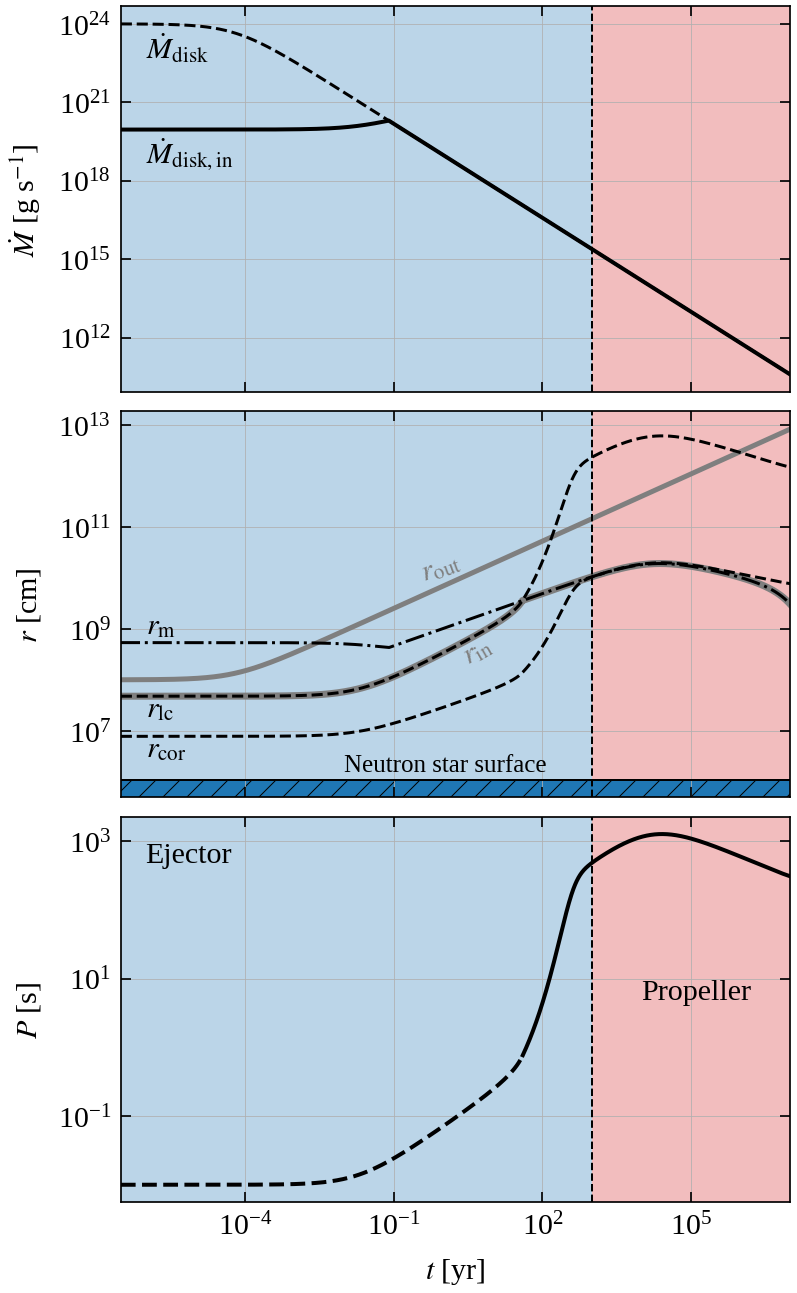

In [18]:
# Plot the spin period evolution.
mask1 = r_m >= r_lc
mask2 = r_m < r_lc

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, gridspec_kw = {'wspace':0, 'hspace':0.05}, figsize=(12,22))

ax1.set_xscale('log') 
ax1.set_yscale('log')
ax1.set_xlim(10/const.YR_TO_S, t_max)
ax1.set_ylabel(r'$\dot{M}$ [g s$^{-1}$]')

ax2.set_xscale('log') 
ax2.set_yscale('log')
ax2.set_ylabel(r'$r$ [cm]')

ax3.set_xscale('log') 
ax3.set_yscale('log')
ax3.set_xlabel(r'$t$ [yr]')
ax3.set_ylabel(r'$P$ [s]')

ax1.plot( 
    time, 
    Mdot_d, 
    linestyle='--',
    linewidth=3,
    color="black",
)
ax1.text(1.e-6, Mdot_d[0]/20, r'$\dot{M}_{\rm disk}$', fontsize = 30, rotation=0, color = 'black')
ax1.plot( 
    time, 
    Mdot_din, 
    linestyle='-',
    linewidth=4,
    color="black",
)
ax1.text(1.e-6, Mdot_din[0]/20, r'$\dot{M}_{\rm disk, in}$', fontsize = 30, rotation=0, color = 'black')

ax1.axvline(
    x=t_prop, 
    color='black', 
    linestyle='--',
    linewidth=2,
    rasterized=True,
)
ax1.axvspan(
    xmin=10 / const.YR_TO_S, 
    xmax=t_prop, 
    facecolor='tab:blue', 
    alpha=0.3,
    rasterized=True,
)
ax1.axvspan(
    xmin=t_prop, 
    xmax=t_max, 
    facecolor='tab:red', 
    alpha=0.3,
    rasterized=True,
)

ax2.plot( 
    time, 
    r_out, 
    linestyle='-',
    linewidth=5,
    color="tab:gray",
)
ax2.plot( 
    time, 
    r_in, 
    linestyle='-',
    linewidth=7,
    color="tab:gray",
)
ax2.plot( 
    time, 
    r_lc, 
    linestyle='--',
    linewidth=3,
    color="black",
)
ax2.plot( 
    time, 
    r_c, 
    linestyle='--',
    linewidth=3,
    color="black",
)
ax2.plot( 
    time, 
    r_m, 
    linestyle='-.',
    linewidth=3,
    color="black",
)

ax2.axvline(
    x=t_prop, 
    color='black', 
    linestyle='--',
    linewidth=2,
    rasterized=True,
)
ax2.axvspan(
    xmin=10 / const.YR_TO_S, 
    xmax=t_prop, 
    facecolor='tab:blue', 
    alpha=0.3,
    rasterized=True,
)
ax2.axvspan(
    xmin=t_prop, 
    xmax=t_max, 
    facecolor='tab:red', 
    alpha=0.3,
    rasterized=True,
)

ax2.axhline(
    y=NS_radius, 
    color='black', 
    linestyle='-',
    linewidth=2,
    rasterized=True,
)
ax2.axhspan(
    ymin=0., 
    ymax=NS_radius, 
    facecolor='tab:blue',
    hatch='/',
    alpha=1,
    rasterized=True,
)
ax2.text(1.e-6, r_m[0]*1.5, r'$r_{\rm m}$', fontsize = 30, rotation=0, color = 'black')
ax2.text(1.e-6, r_lc[0]/2.5, r'$r_{\rm lc}$', fontsize = 30, rotation=0, color = 'black')
ax2.text(1.e-6, r_c[0]/2.5, r'$r_{\rm cor}$', fontsize = 30, rotation=0, color = 'black')
ax2.text(2, r_in[900], r'$r_{\rm in}$', fontsize = 30, rotation=30, color = 'tab:gray')
ax2.text(0.3, r_out[1000], r'$r_{\rm out}$', fontsize = 30, rotation=20, color = 'tab:gray')
ax2.text(1.e-2, NS_radius*1.5, r'Neutron star surface', fontsize = 25, rotation=0, color = 'black')

ax3.text(1.e-6, 5.e2, r'Ejector', fontsize = 30, rotation=0, color = 'black')
ax3.text(t_prop*10, 5., r'Propeller', fontsize = 30, rotation=0, color = 'black')

ax3.plot(
    np.ma.masked_where(mask1, time),
    np.ma.masked_where(mask1, P),
    color="black",
    linestyle='-',
    linewidth=4,
    rasterized=True,
)
ax3.plot(
    np.ma.masked_where(mask2, time),
    np.ma.masked_where(mask2, P),
    color="black",
    linestyle='--',
    linewidth=4,
    rasterized=True,
)

ax3.axvline(
    x=t_prop, 
    color='black', 
    linestyle='--',
    linewidth=2,
    rasterized=True,
)
ax3.axvspan(
    xmin=10 / const.YR_TO_S, 
    xmax=t_prop, 
    facecolor='tab:blue', 
    alpha=0.3,
    rasterized=True,
)
ax3.axvspan(
    xmin=t_prop, 
    xmax=t_max, 
    facecolor='tab:red', 
    alpha=0.3,
    rasterized=True,
)

ax1.grid()
ax2.grid()
ax3.grid()

#fig.savefig("propeller_evolution_ex_Bdecay.pdf", bbox_inches="tight")
plt.show()

## Examples of spin period evolution varying $B_{\rm 0}$ and $\dot{M}_{\rm d,0}$

In [19]:
# Define a grid of values for Mdot_d0 and B0.
log_Mdot_d0_edges1 = np.linspace(np.log10(Mdot_d0_min)-0.5, np.log10(Mdot_d0_max)+0.5, 12)
log_Mdot_d0_centers1 = 0.5 * (log_Mdot_d0_edges1[1:] + log_Mdot_d0_edges1[:-1])
Mdot_d0_edges1 = 10**log_Mdot_d0_edges1
Mdot_d0_centers1 = 10**log_Mdot_d0_centers1

log_B0_edges1 = np.linspace(np.log10(B0_min)-0.25, np.log10(B0_max)+0.25, 8)
log_B0_centers1 = 0.5 * (log_B0_edges1[1:] + log_B0_edges1[:-1])
B0_edges1 = 10**log_B0_edges1
B0_centers1 = 10**log_B0_centers1

Spin-period evolution for several values of the initial magnetic field $B_0$ and varying initial disk accretion rate $\dot{M}_{\rm d,0}$ (see fig. 3 in [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704)).

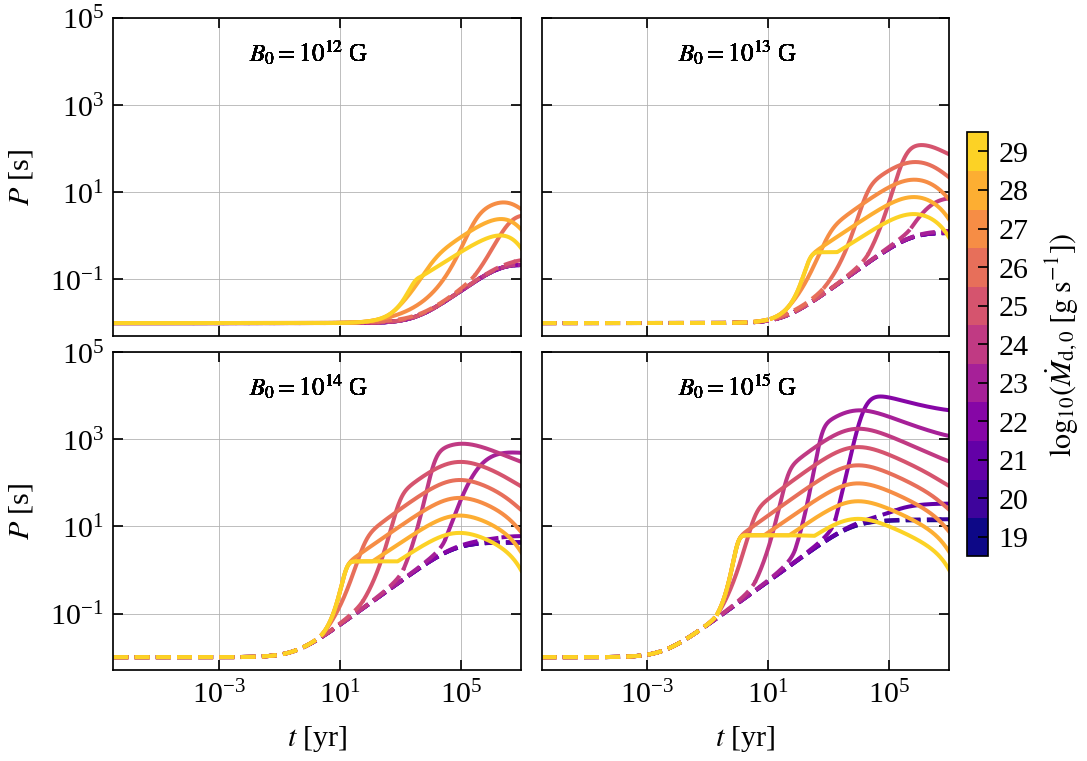

In [20]:
# Plot the spin period evolution.
fig, axs = plt.subplots(2, 2, figsize=(18,12)) 

for ax in axs.flat:
    ax.set(xlabel=r'$t$ [yr]', ylabel=r'$P$ [s]')
    ax.set(xscale='log', yscale='log')
    ax.set(xlim=(10 / const.YR_TO_S, t_max), ylim=(5.e-3, 1.e5))
    #ax.set(ylim=(5.e-3, 1.e6))
    ax.grid()
    ax.label_outer()

colors = plt.get_cmap("plasma", len(Mdot_d0_centers1)+1)

norm= mpl.colors.BoundaryNorm(log_Mdot_d0_edges1, len(Mdot_d0_centers1))
sm = plt.cm.ScalarMappable(norm=norm, cmap=colors)
sm.set_array([])

for i in range(len(Mdot_d0_centers1)):
    # B0 = 10^12 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e12, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[0,0].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].text(
        1.e-2, 1.e4,
        r'$B_0 = 10^{12}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^13 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e13, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[0,1].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].text(
        1.e-2, 1.e4,
        r'$B_0 = 10^{13}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^14 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e14, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,0].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].text(
        1.e-2, 1.e4,
        r'$B_0 = 10^{14}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^15 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e15, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,1].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].text(
        1.e-2, 1.e4,
        r'$B_0 = 10^{15}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
      
cbar = fig.colorbar(sm, ticks=np.log10(Mdot_d0_centers1), ax=axs.ravel().tolist(), shrink=0.65)
cbar.set_label(r'$\log_{10}(\dot{M}_{\rm d,0} \; \rm{[g \; s}^{-1}])$')

fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

#fig.savefig("P_evolution_Mdot_Bdecay.pdf", bbox_inches="tight")
plt.show()

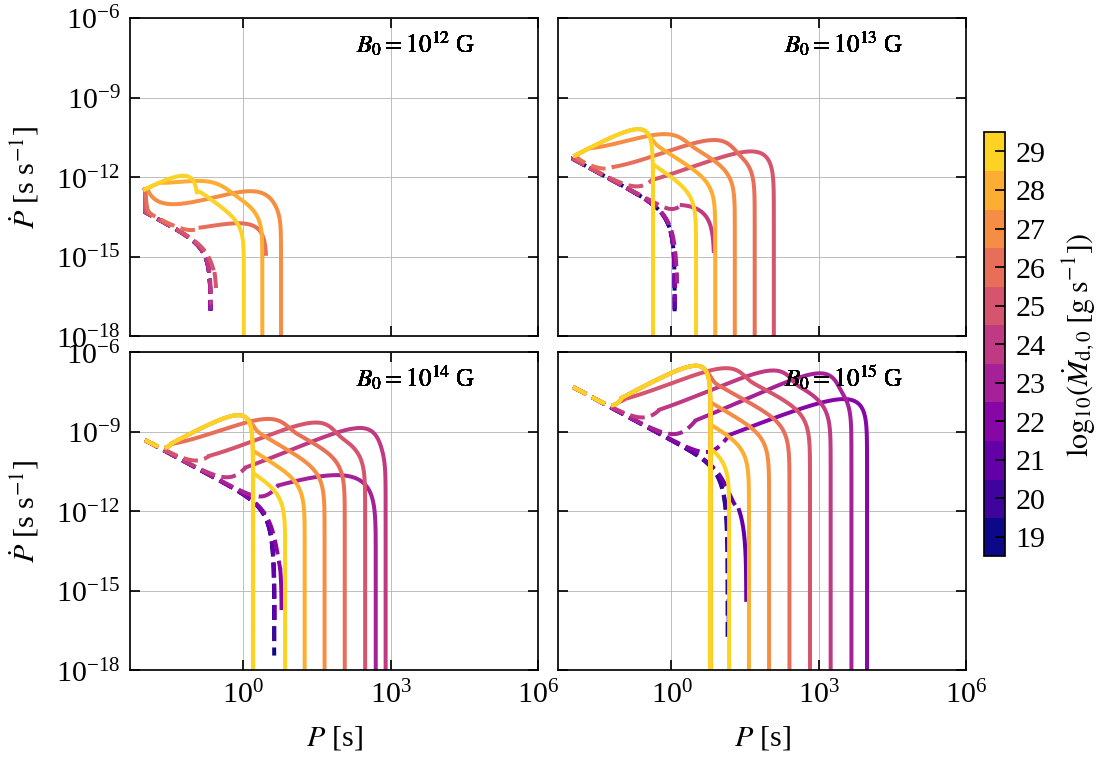

In [21]:
# Plot the evolution in P-Pdot plane.
fig, axs = plt.subplots(2, 2, figsize=(18,12)) 

for ax in axs.flat:
    ax.set(xlabel=r'$P$ [s]', ylabel=r'$\dot{P}$ [s s$^{-1}$]')
    ax.set(xscale='log', yscale='log')
    ax.set(xlim=(5.e-3, 1.e6), ylim=(1.e-18, 1.e-6))
    ax.grid()
    ax.label_outer()

colors = plt.get_cmap("plasma", len(Mdot_d0_centers1)+1)

norm= mpl.colors.BoundaryNorm(log_Mdot_d0_edges1, len(Mdot_d0_centers1))
sm = plt.cm.ScalarMappable(norm=norm, cmap=colors)
sm.set_array([])

for i in range(len(Mdot_d0_centers1)):
    # B0 = 10^12 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e12, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[0,0].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].text(
        2.e2, 5.e-8,
        r'$B_0 = 10^{12}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^13 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e13, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[0,1].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].text(
        2.e2, 5.e-8,
        r'$B_0 = 10^{13}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^14 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e14, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,0].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].text(
        2.e2, 5.e-8,
        r'$B_0 = 10^{14}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # B0 = 10^15 G.
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(1.e15, P_in, Mdot_d0_centers1[i], alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,1].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].text(
        2.e2, 5.e-8,
        r'$B_0 = 10^{15}$ G', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
      
cbar = fig.colorbar(sm, ticks=np.log10(Mdot_d0_centers1), ax=axs.ravel().tolist(), shrink=0.65)
cbar.set_label(r'$\log_{10}(\dot{M}_{\rm d,0} \; \rm{[g \; s}^{-1}])$')

fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

#fig.savefig("PPdot_evolution_Mdot_Bdecay.pdf", bbox_inches="tight")
plt.show()

Spin-period evolution for several values of the initial disk accretion rate $\dot{M}_{\rm d,0}$ and varying initial magnetic field $B_0$ (see fig. 4 in [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704)).

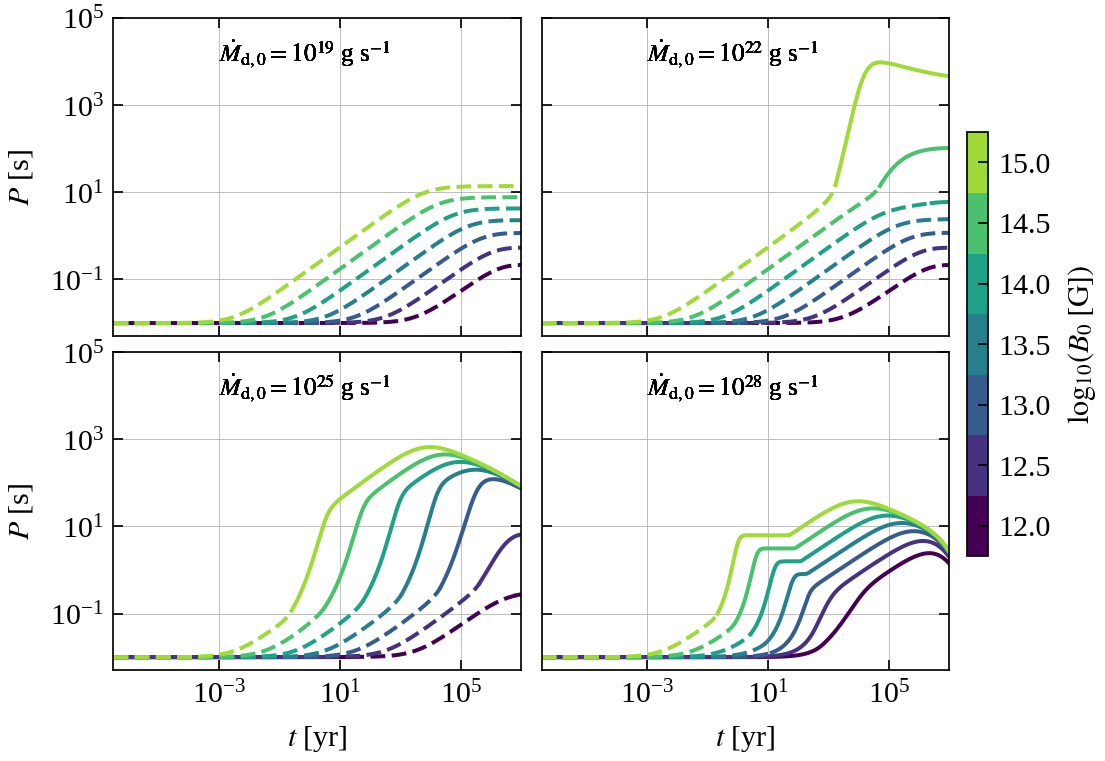

In [22]:
# Plot the spin period evolution
fig, axs = plt.subplots(2, 2, figsize=(18,12)) 

for ax in axs.flat:
    ax.set(xlabel=r'$t$ [yr]', ylabel=r'$P$ [s]')
    ax.set(xscale='log', yscale='log')
    ax.set(xlim=(10 / const.YR_TO_S, t_max), ylim=(5.e-3, 1.e5))
    ax.grid()
    ax.label_outer()

colors = plt.get_cmap("viridis", len(B0_centers1)+1)

norm= mpl.colors.BoundaryNorm(log_B0_edges1, len(B0_centers1))
sm = plt.cm.ScalarMappable(norm=norm, cmap=colors)
sm.set_array([])

for i in range(len(B0_centers1)):
    # Mdot_d0 = 10^19 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e19, alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[0,0].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].text(
        1.e-3, 1.e4,
        r'$\dot{M}_{\rm d,0} = 10^{19}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^22 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e22, alpha, t_max)
    
    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[0,1].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].text(
        1.e-3, 1.e4,
        r'$\dot{M}_{\rm d,0} = 10^{22}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^25 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e25, alpha, t_max)
    
    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[1,0].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].text(
        1.e-3, 1.e4,
        r'$\dot{M}_{\rm d,0} = 10^{25}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^28 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e28, alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc

    axs[1,1].plot( 
        np.ma.masked_where(mask1, time),
        np.ma.masked_where(mask1, P),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].plot( 
        np.ma.masked_where(mask2, time),
        np.ma.masked_where(mask2, P),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].text(
        1.e-3, 1.e4,
        r'$\dot{M}_{\rm d,0} = 10^{28}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
        
cbar = fig.colorbar(sm, ticks=np.log10(B0_centers1), ax=axs.ravel().tolist(), shrink=0.65)
cbar.set_label(r'$\log_{10}(B_0 \; \rm{[G]})$')

fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

#fig.savefig("P_evolution_B_Bdecay.pdf", bbox_inches="tight")
plt.show()

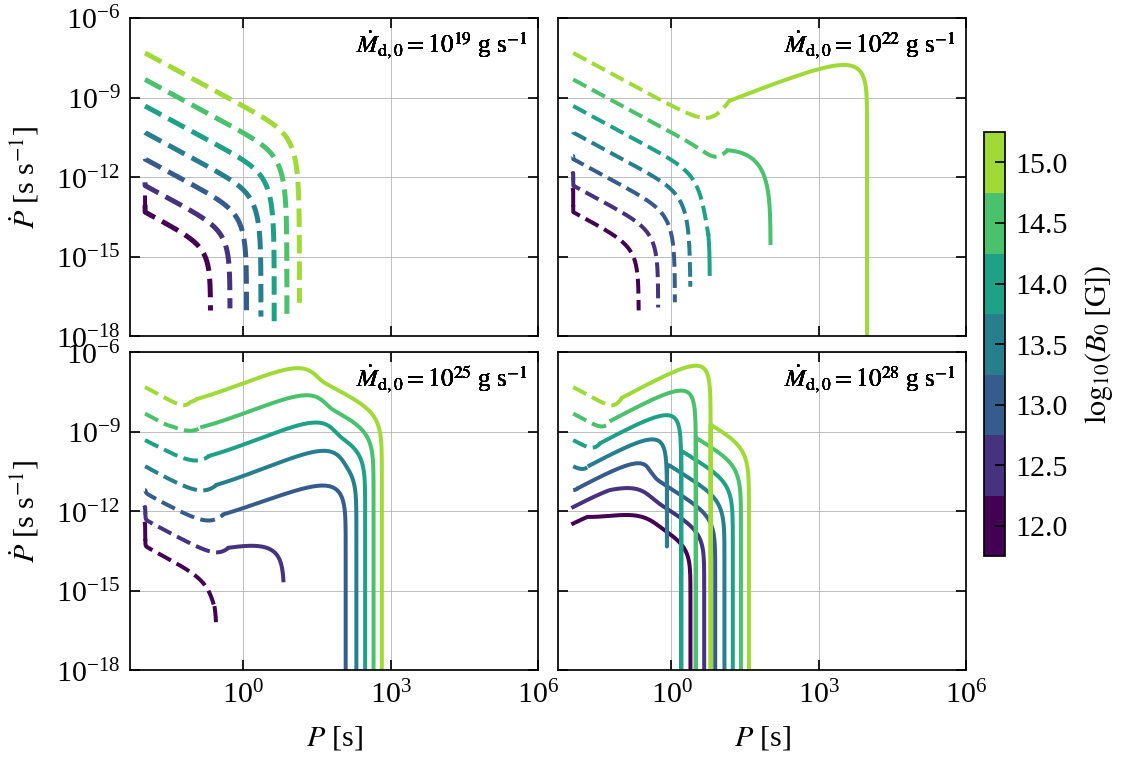

In [23]:
# Plot the evolution in P-Pdot plane.
fig, axs = plt.subplots(2, 2, figsize=(18,12)) 

for ax in axs.flat:
    ax.set(xlabel=r'$P$ [s]', ylabel=r'$\dot{P}$ [s s$^{-1}$]')
    ax.set(xscale='log', yscale='log')
    ax.set(xlim=(5.e-3, 1.e6), ylim=(1.e-18, 1.e-6))
    #ax.set(ylim=(5.e-3, 1.e6))
    ax.grid()
    ax.label_outer()

colors = plt.get_cmap("viridis", len(B0_centers1)+1)

norm= mpl.colors.BoundaryNorm(log_B0_edges1, len(B0_centers1))
sm = plt.cm.ScalarMappable(norm=norm, cmap=colors)
sm.set_array([])

for i in range(len(B0_centers1)):
    # Mdot_d0 = 10^19 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e19, alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[0,0].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=5,
        color=colors(i),
        rasterized=True,
    )
    axs[0,0].text(
        2.e2, 5.e-8,
        r'$\dot{M}_{\rm d,0} = 10^{19}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^22 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e22, alpha, t_max)
    
    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[0,1].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[0,1].text(
        2.e2, 5.e-8,
        r'$\dot{M}_{\rm d,0} = 10^{22}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^25 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e25, alpha, t_max)
    
    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,0].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,0].text(
        2.e2, 5.e-8,
        r'$\dot{M}_{\rm d,0} = 10^{25}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
    
    # Mdot_d0 = 10^28 g/s
    time, P, Pdot, _, r_m, r_c, r_lc, _, _, _, _, _ = rotational_evolution(B0_centers1[i], P_in, 1.e28, alpha, t_max)

    mask1 = r_m >= r_lc
    mask2 = r_m < r_lc
    
    axs[1,1].plot( 
        np.ma.masked_where(mask1, P),
        np.ma.masked_where(mask1, Pdot),
        linestyle='-',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].plot( 
        np.ma.masked_where(mask2, P),
        np.ma.masked_where(mask2, Pdot),
        linestyle='--',
        linewidth=4,
        color=colors(i),
        rasterized=True,
    )
    axs[1,1].text(
        2.e2, 5.e-8,
        r'$\dot{M}_{\rm d,0} = 10^{28}$ g s$^{-1}$', 
        fontsize = 25, 
        rotation=0, 
        color = 'black'
    )
            
cbar = fig.colorbar(sm, ticks=np.log10(B0_centers1), ax=axs.ravel().tolist(), shrink=0.65)
cbar.set_label(r'$\log_{10}(B_0 \; \rm{[G]})$')


fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

#fig.savefig("PPdot_evolution_B_Bdecay.pdf", bbox_inches="tight")
plt.show()

## Parameter search for GLEAM-X J162759.5-523504.3 and MTP0013.

Search the parameter combinations of the initial disk accretion rate $\dot{M}_{\rm d,0}$ and initial magnetic field $B_0$ that guarantee the neutron star to reach at least the spin periods of GLEAM-X J162759.5-523504.3 and MTP0013 (see fig. 5 in [Ronchi et al. 2022](https://arxiv.org/abs/2201.11704)). We check also the case of 1E 161348-5055.

In [24]:
P_GLEAM = 1091.  # GLEAM-X J162759.5-523504.3 spin period in [s].
P_MTP = 75.9  # MTP0013 spin period in [s].
P_1E = 6.67*3600  # 1E 161348-5055 spin period in [s].

# Define a grid for the parameters Mdot_d0 and B0.
n_bins = 20

log_Mdot_d0_edges = np.linspace(np.log10(Mdot_d0_min), np.log10(Mdot_d0_max), n_bins+1)
log_Mdot_d0_centers = 0.5 * (log_Mdot_d0_edges[1:] + log_Mdot_d0_edges[:-1])
Mdot_d0_edges = 10**log_Mdot_d0_edges
Mdot_d0_centers = 10**log_Mdot_d0_centers

log_B0_edges = np.linspace(np.log10(B0_min), np.log10(B0_max), n_bins+1)
log_B0_centers = 0.5 * (log_B0_edges[1:] + log_B0_edges[:-1])
B0_edges = 10**log_B0_edges
B0_centers = 10**log_B0_centers

# Initialize the array where to save the needed information.
t_found_MTP = np.zeros((len(Mdot_d0_centers), len(B0_centers)))
B0_tfound_MTP = np.zeros((len(Mdot_d0_centers), len(B0_centers)))
Erotdot_MTP = np.zeros((len(Mdot_d0_centers), len(B0_centers)))

t_found_GLEAM = np.zeros((len(Mdot_d0_centers), len(B0_centers)))
B0_tfound_GLEAM = np.zeros((len(Mdot_d0_centers), len(B0_centers)))
Erotdot_GLEAM = np.zeros((len(Mdot_d0_centers), len(B0_centers)))

t_found_1E = np.zeros((len(Mdot_d0_centers), len(B0_centers)))

In [25]:
# Evolve the spin period in time for every parameter combination.
for i, mdot_di in enumerate(Mdot_d0_centers):
    for ii, B0i in enumerate(B0_centers):
        t_model, P_model, Pdot_model, B_model, r_m, _, r_lc, _, _, buried, disk_disrupted, _ = rotational_evolution(B0i, P_in, mdot_di, alpha, t_max)
        
        r_in = np.minimum(r_m, r_lc)
        r_out = disk_outer_radius_t(t_model * const.YR_TO_S)
        
        # Compute the spin-down power.
        Erot_dot = NS_inertia * 4 * np.pi**2 * Pdot_model / P_model**3
        
        # Save the time when the spin period reaches its maximum value.
        t_Pmax = t_model[P_model==np.max(P_model)]
        
        if any(P_model >= P_GLEAM) & (buried is False):
            # Save the time when P = P_GLEAM.
            t_found_GLEAM[i, ii] = np.interp(P_GLEAM, P_model[t_model<=t_Pmax], t_model[t_model<=t_Pmax])
            # Save the value of the magnetic field at t = t_found.
            B0_tfound_GLEAM = np.interp(t_found_GLEAM[i, ii], t_model[t_model<=t_Pmax], B_model[t_model<=t_Pmax])
            # Save the spin-down power at t = t_found.
            Pdot_em_GLEAM = 4 * np.pi**2 * beta_1 * B0_tfound_GLEAM ** 2 / P_GLEAM
            Erotdot_GLEAM[i, ii] = NS_inertia * (2.*np.pi)**2 * Pdot_em_GLEAM / (P_GLEAM ** 3)
                    
        if any(P_model >= P_MTP) & (buried is False):
            # Save the time when P = P_MTP.
            t_found_MTP[i, ii] = np.interp(P_MTP, P_model[t_model<=t_Pmax], t_model[t_model<=t_Pmax])
            # Save the value of the magnetic field at t = t_found.
            B0_tfound_MTP[i, ii] = np.interp(t_found_MTP[i, ii], t_model[t_model<=t_Pmax], B_model[t_model<=t_Pmax])
            # Save the spin-down power at t = t_found.
            Pdot_em_MTP = 4 * np.pi**2 * beta_1 * B0_tfound_MTP[i, ii] ** 2 / P_MTP
            Erotdot_MTP[i, ii] = NS_inertia * (2.*np.pi)**2 * Pdot_em_MTP/ (P_MTP ** 3)
        
        if any(P_model >= P_1E) & (buried is False):
            # Save the time when P = P_1E.
            t_found_1E[i, ii] = np.interp(P_1E, P_model[t_model<=t_Pmax], t_model[t_model<=t_Pmax])
            
    print(i)
                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [26]:
# Evaluate the total accreted mass in the disk in the time t = t_found.
Mdot_d0_grid, B0_grid = np.meshgrid(Mdot_d0_centers, B0_centers, indexing='ij')

M_d_tot_MTP = np.zeros((len(Mdot_d0_grid), len(B0_grid)))
M_d_tot_GLEAM = np.zeros((len(Mdot_d0_grid), len(B0_grid)))
M_d_tot_1E = np.zeros((len(Mdot_d0_grid), len(B0_grid)))

for i in range(len(Mdot_d0_grid)):
    for ii in range(len(B0_grid)):
        if t_found_MTP[i, ii] != 0.:
            t_integration = np.logspace(np.log10(10.), np.log10(t_found_MTP[i, ii] * const.YR_TO_S), 100)
            M_d_tot_MTP[i, ii] = trapz(disk_accretion_rate_t(Mdot_d0_grid[i, ii], alpha, t_integration), t_integration)
    
        if t_found_GLEAM[i, ii] != 0.:
            t_integration = np.logspace(np.log10(10.), np.log10(t_found_GLEAM[i, ii] * const.YR_TO_S), 100)
            M_d_tot_GLEAM[i, ii] = trapz(disk_accretion_rate_t(Mdot_d0_grid[i, ii], alpha, t_integration), t_integration)
        
        if t_found_1E[i, ii] != 0.:
            t_integration = np.logspace(np.log10(10.), np.log10(t_found_1E[i, ii] * const.YR_TO_S), 100)
            M_d_tot_1E[i, ii] = trapz(disk_accretion_rate_t(Mdot_d0_grid[i, ii], alpha, t_integration), t_integration)

In [27]:
# Fiducial region of uncertainty of 5 % on the MTP0013 magnetic field estimation.
B_MTP_min = 10**(np.log10(1.3e14) - 0.05*np.log10(1.3e14))
B_MTP_max = 10**(np.log10(1.3e14) + 0.05*np.log10(1.3e14))

/tmp/ipykernel_13282/639058723.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(t_found_GLEAM).T,
/tmp/ipykernel_13282/639058723.py:27: RuntimeWarning: divide by zero encountered in log10
  np.log10(M_d_tot_GLEAM / const.M_SUN).T,
/tmp/ipykernel_13282/639058723.py:44: RuntimeWarning: divide by zero encountered in log10
  np.log10(t_found_MTP).T,
/tmp/ipykernel_13282/639058723.py:54: RuntimeWarning: divide by zero encountered in log10
  np.log10(M_d_tot_MTP / const.M_SUN).T,
/tmp/ipykernel_13282/639058723.py:68: RuntimeWarning: divide by zero encountered in log10
  np.log10(B0_tfound_MTP).T,


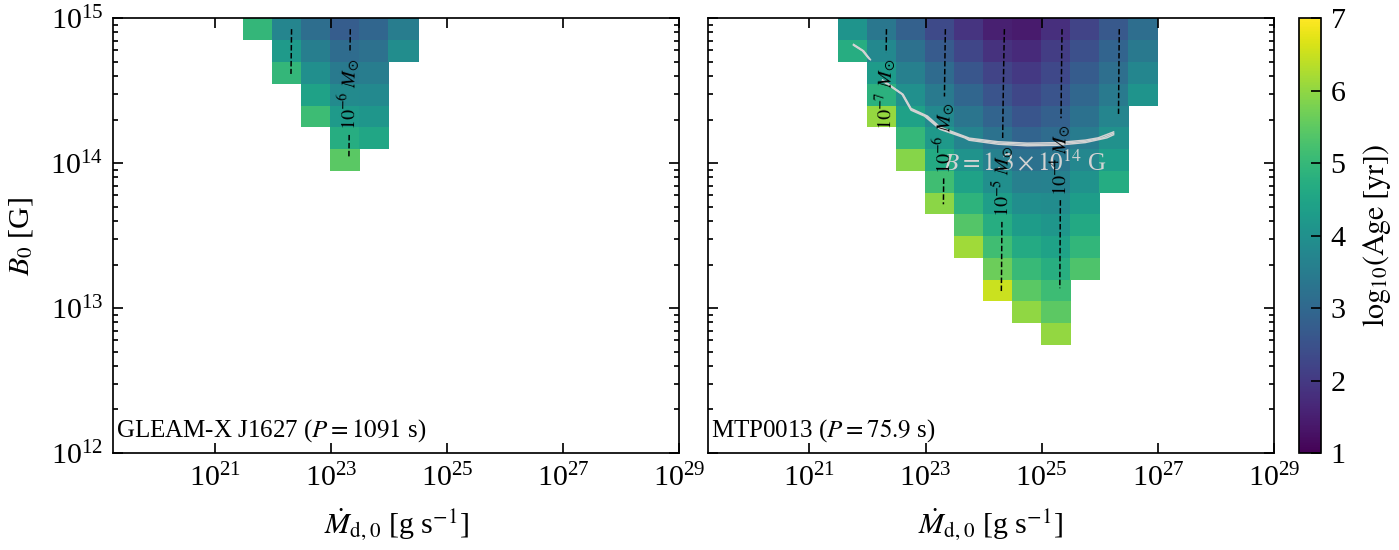

In [28]:
# Plot a color map of the founded parameter combinations for GLEAM-X J162759.5-523504.3 and MTP0013. 
fig, axs = plt.subplots(1, 2, figsize=(25,8)) 

norm = mpl.colors.Normalize(vmin=1, vmax=np.log10(t_max))
cmap = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

for ax in axs.flat:
    ax.set(xlabel=r'$\dot{M}_{\rm d,0}$ [g s$^{-1}$]', ylabel=r'$B_0$ [G]')
    ax.set(xscale='log', yscale='log')
    ax.label_outer()

axs[0].text(2.e19, 1.3e12, r'GLEAM-X J1627 ($P=1091$ s)', fontsize = 25, rotation=0, color = 'black')
#axs[0].grid()
cmesh_GLEAM = axs[0].pcolormesh(
    Mdot_d0_edges,
    B0_edges,
    np.log10(t_found_GLEAM).T, 
    cmap="viridis",
    vmin=1,
    vmax=np.log10(t_max),
    alpha=1, 
    rasterized=True,
)
contour_GLEAM = axs[0].contour(
    Mdot_d0_centers,
    B0_centers,
    np.log10(M_d_tot_GLEAM / const.M_SUN).T, 
    levels = np.array([-10,-9,-8,-7,-6,-5,-4,-3,-2]), 
    colors='k',
    #interpolation='none'
)
fmt = {}
strs = ['$10^{-10}$ $M_{\odot}$', '$10^{-9}$ $M_{\odot}$', '$10^{-8}$ $M_{\odot}$', '$10^{-7}$ $M_{\odot}$', '$10^{-6}$ $M_{\odot}$', '$10^{-5}$ $M_{\odot}$', '$10^{-4}$ $M_{\odot}$', '$10^{-3}$ $M_{\odot}$', '$10^{-2}$ $M_{\odot}$']
for l,s in zip( contour_GLEAM.levels, strs ):
    fmt[l] = rf"{s}"
axs[0].clabel(contour_GLEAM, contour_GLEAM.levels, inline=True, fmt=fmt, fontsize=20)


axs[1].text(2.e19, 1.3e12, r'MTP0013 ($P=75.9$ s)', fontsize = 25, rotation=0, color = 'black')
#axs[0].grid()
cmesh_MTP = axs[1].pcolormesh(
    Mdot_d0_edges,
    B0_edges,
    np.log10(t_found_MTP).T, 
    cmap="viridis",
    vmin=1,
    vmax=np.log10(t_max),
    alpha=1, 
    rasterized=True,
)
contour_MTP = axs[1].contour(
    Mdot_d0_centers,
    B0_centers,
    np.log10(M_d_tot_MTP / const.M_SUN).T, 
    levels = np.array([-10,-9,-8,-7,-6,-5,-4,-3,-2]), 
    colors='k',
    #interpolation='none'
)
fmt = {}
strs = ['$10^{-10}$ $M_{\odot}$', '$10^{-9}$ $M_{\odot}$', '$10^{-8}$ $M_{\odot}$', '$10^{-7}$ $M_{\odot}$', '$10^{-6}$ $M_{\odot}$', '$10^{-5}$ $M_{\odot}$', '$10^{-4}$ $M_{\odot}$', '$10^{-3}$ $M_{\odot}$', '$10^{-2}$ $M_{\odot}$']
for l,s in zip( contour_MTP.levels, strs ):
    fmt[l] = rf"{s}"
axs[1].clabel(contour_MTP, contour_MTP.levels, inline=True, fmt=fmt, fontsize=20)

contour_B_MTP = axs[1].contour(
    Mdot_d0_centers,
    B0_centers,
    np.log10(B0_tfound_MTP).T, 
    levels = np.array([np.log10(1.27e14),np.log10(1.3e14),np.log10(1.33e14)]), 
    colors='lightgray',
    #interpolation='none'
)
axs[1].text(2.e23, 9.e13, r'$B=1.3 \times 10^{14}$ G', fontsize = 25, rotation=0, color = 'lightgray')

cbar = fig.colorbar(cmap, ax=axs.ravel().tolist())
cbar.set_label(r'$\log_{10}(\rm Age \; \rm{[yr]})$')

fig.set_tight_layout(False)
fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.77)

#plt.savefig("age_B_Mdot_GLEAM_MTP_Bdecay.pdf", bbox_inches="tight")

plt.show()

In order to find an allowed parameter space also for 1E 161348-5055, the range of magnetic field should be increased up to $10^{16}$ G and the initial circularization radius of the disk should be increased as well to a value $r_{\rm d} \sim 5 \times 10^8$ cm. In this way one can find that 1E 161348-5055 can ba a neutron star with a very strong magnetic field $\sim 5 \times 10^{15}$ G interacting with a disk with initial accretion rate of around $\sim 10^{21}$ g s$^{-1}$.

/tmp/ipykernel_13282/2538303407.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(t_found_1E).T,
/tmp/ipykernel_13282/2538303407.py:29: RuntimeWarning: divide by zero encountered in log10
  np.log10(M_d_tot_1E / const.M_SUN).T,
/home/michele/miniconda3/envs/pulsar_fallback/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/michele/miniconda3/envs/pulsar_fallback/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_13282/2538303407.py:26: UserWarning: No contour levels were found within the data range.
  contour_1E = ax.contour(


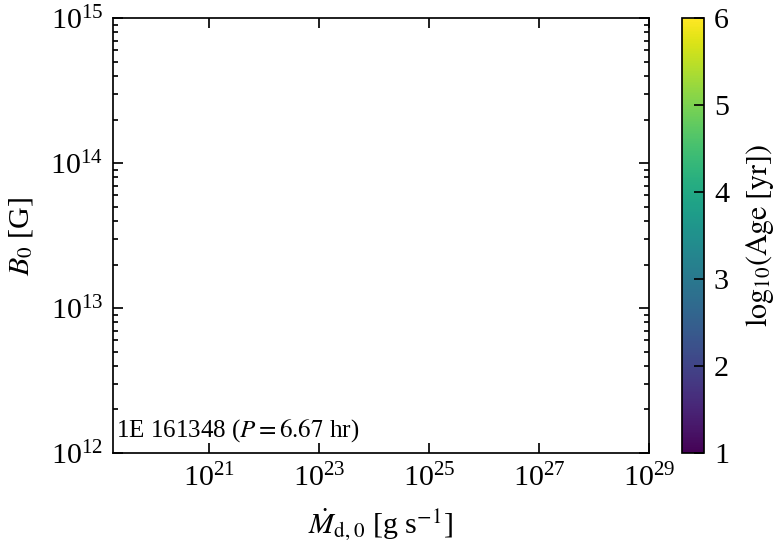

In [29]:
# Plot a color map of the founded parameter combinations for 1E 161348-5055. 
#t_1E_mask = (t_found_1E > 3200.) | (t_found_1E < 1200.)
#t_found_1E[t_1E_mask] = np.nan
#M_fb_tot_1E[t_1E_mask] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(12,8)) 

norm = mpl.colors.Normalize(vmin=1, vmax=6)
cmap = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

ax.set(xlabel=r'$\dot{M}_{\rm d,0}$ [g s$^{-1}$]', ylabel=r'$B_0$ [G]')
ax.set(xscale='log', yscale='log')
   
#ax.grid()
ax.text(2.e19, 1.3e12, r'1E 161348 ($P=6.67$ hr)', fontsize = 25, rotation=0, color = 'black')
cmesh_1E = ax.pcolormesh(
    Mdot_d0_edges,
    B0_edges,
    np.log10(t_found_1E).T, 
    cmap="viridis",
    vmin=1,
    vmax=6,
    alpha=1, 
    rasterized=True,
)
contour_1E = ax.contour(
    Mdot_d0_centers,
    B0_centers,
    np.log10(M_d_tot_1E / const.M_SUN).T, 
    levels = np.array([-10,-9,-8,-7,-6,-5,-4,-3,-2]), 
    colors='k',
    #interpolation='none'
)
fmt = {}
strs = ['$10^{-10}$ $M_{\odot}$', '$10^{-9}$ $M_{\odot}$', '$10^{-8}$ $M_{\odot}$', '$10^{-7}$ $M_{\odot}$', '$10^{-6}$ $M_{\odot}$', '$10^{-5}$ $M_{\odot}$', '$10^{-4}$ $M_{\odot}$', '$10^{-3}$ $M_{\odot}$', '$10^{-2}$ $M_{\odot}$']
for l,s in zip( contour_1E.levels, strs ):
    fmt[l] = rf"{s}"   
ax.clabel(contour_1E, contour_1E.levels, inline=True, fmt=fmt, fontsize=20)

cbar = fig.colorbar(cmap, ax=ax)
cbar.set_label(r'$\log_{10}(\rm Age \; \rm{[yr]})$')

fig.set_tight_layout(False)

#plt.savefig("age_B_Mdot_1E_Bdecay.pdf", bbox_inches="tight")

plt.show()